# Source 
https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

# tqdm to enable progress bars for training and testing loops
from tqdm.notebook import tqdm


from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
moods = ['calm', 'energetic', 'happy', 'sad']

In [3]:
files = []
for g in moods:
    for filename in os.listdir(f'./{g}'):
        file_name = f'./{g}/{filename}'
        files.append(file_name)

In [4]:
combined_df = pd.concat([pd.read_csv(file) for file in files])

In [5]:
# combined_df.set_index('id')
combined_df.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,mood
0,0,0.453,0.04360,10,-25.912,0,0.0364,0.990,0.842,0.1110,0.1980,71.987,audio_features,7FyzToHhKG9b9gS19kWg8a,spotify:track:7FyzToHhKG9b9gS19kWg8a,https://api.spotify.com/v1/tracks/7FyzToHhKG9b...,https://api.spotify.com/v1/audio-analysis/7Fyz...,166000,4,calm
1,1,0.437,0.01840,8,-30.783,1,0.0413,0.994,0.930,0.1140,0.0478,119.985,audio_features,5a8V9tjazhBAIbUiFqpu8N,spotify:track:5a8V9tjazhBAIbUiFqpu8N,https://api.spotify.com/v1/tracks/5a8V9tjazhBA...,https://api.spotify.com/v1/audio-analysis/5a8V...,205794,4,calm
2,2,0.366,0.01610,5,-27.355,1,0.0632,0.992,0.951,0.1100,0.1710,49.668,audio_features,3WiissyVFRpCVrqbyPKZxZ,spotify:track:3WiissyVFRpCVrqbyPKZxZ,https://api.spotify.com/v1/tracks/3WiissyVFRpC...,https://api.spotify.com/v1/audio-analysis/3Wii...,121068,4,calm
3,3,0.385,0.00786,0,-25.033,1,0.0546,0.996,0.843,0.0928,0.1290,74.284,audio_features,3orRX2Ms4jy4dU9KqJ9zT1,spotify:track:3orRX2Ms4jy4dU9KqJ9zT1,https://api.spotify.com/v1/tracks/3orRX2Ms4jy4...,https://api.spotify.com/v1/audio-analysis/3orR...,180000,4,calm
4,4,0.381,0.00324,6,-33.019,0,0.0351,0.994,0.885,0.0746,0.0839,101.624,audio_features,536rm114S2ByPbh906pksj,spotify:track:536rm114S2ByPbh906pksj,https://api.spotify.com/v1/tracks/536rm114S2By...,https://api.spotify.com/v1/audio-analysis/536r...,156000,4,calm


In [6]:
train_col = ['id','danceability', 'energy', 'key', 'mode', 
             'speechiness', 'acousticness','instrumentalness', 'liveness',
             'valence','tempo','time_signature']
predict_col = 'mood'

In [7]:
df_features = combined_df[train_col + [predict_col]]

In [8]:
df_features.head()

,id,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mood
0,7FyzToHhKG9b9gS19kWg8a,0.453,0.04360,10,0,0.0364,0.990,0.842,0.1110,0.1980,71.987,4,calm
1,5a8V9tjazhBAIbUiFqpu8N,0.437,0.01840,8,1,0.0413,0.994,0.930,0.1140,0.0478,119.985,4,calm
2,3WiissyVFRpCVrqbyPKZxZ,0.366,0.01610,5,1,0.0632,0.992,0.951,0.1100,0.1710,49.668,4,calm
3,3orRX2Ms4jy4dU9KqJ9zT1,0.385,0.00786,0,1,0.0546,0.996,0.843,0.0928,0.1290,74.284,4,calm
4,536rm114S2ByPbh906pksj,0.381,0.00324,6,0,0.0351,0.994,0.885,0.0746,0.0839,101.624,4,calm


In [9]:
df = df_features.copy()
del df['id']

In [10]:
df.head()

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mood
0,0.453,0.04360,10,0,0.0364,0.990,0.842,0.1110,0.1980,71.987,4,calm
1,0.437,0.01840,8,1,0.0413,0.994,0.930,0.1140,0.0478,119.985,4,calm
2,0.366,0.01610,5,1,0.0632,0.992,0.951,0.1100,0.1710,49.668,4,calm
3,0.385,0.00786,0,1,0.0546,0.996,0.843,0.0928,0.1290,74.284,4,calm
4,0.381,0.00324,6,0,0.0351,0.994,0.885,0.0746,0.0839,101.624,4,calm


In [11]:
df.shape


(1769, 12)

<AxesSubplot:>

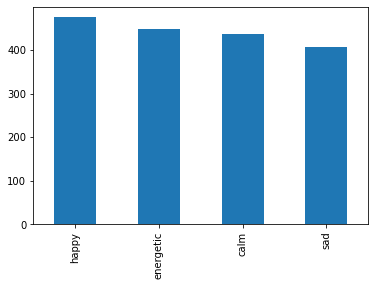

In [12]:
df['mood'].value_counts().plot.bar()

<AxesSubplot:ylabel='mood'>

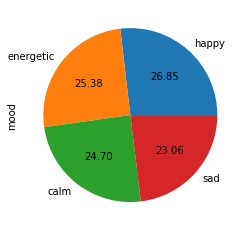

In [13]:
df['mood'].value_counts().plot.pie(autopct='%.2f')

In [14]:
class2idx = {
    'calm':0,
    'energetic':1,
    'happy':2,
    'sad':3
}

idx2class = {v: k for k, v in class2idx.items()}

df['mood'].replace(class2idx, inplace=True)

In [80]:
df.tail()

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mood
75,0.579,0.617,9,1,0.0527,0.0770,0.000547,0.1340,0.392,170.145,4,3
76,0.675,0.413,5,1,0.0351,0.7150,0.000066,0.1040,0.206,139.979,4,3
77,0.649,0.386,2,0,0.0352,0.8290,0.000000,0.1020,0.284,100.023,4,3
78,0.700,0.816,7,0,0.0361,0.0910,0.119000,0.0729,0.632,123.986,4,3
79,0.659,0.717,8,1,0.0581,0.0393,0.000000,0.0769,0.710,103.036,4,3


In [16]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [17]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [18]:
# Normalize Input
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [19]:
# Visualize Class Distribution in Train, Val, and Test
def get_class_distribution(obj):
    count_dict = {
        "calm": 0,
        "energetic": 0,
        "happy": 0,
        "sad": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['calm'] += 1
        elif i == 1: 
            count_dict['energetic'] += 1
        elif i == 2: 
            count_dict['happy'] += 1
        elif i == 3: 
            count_dict['sad'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

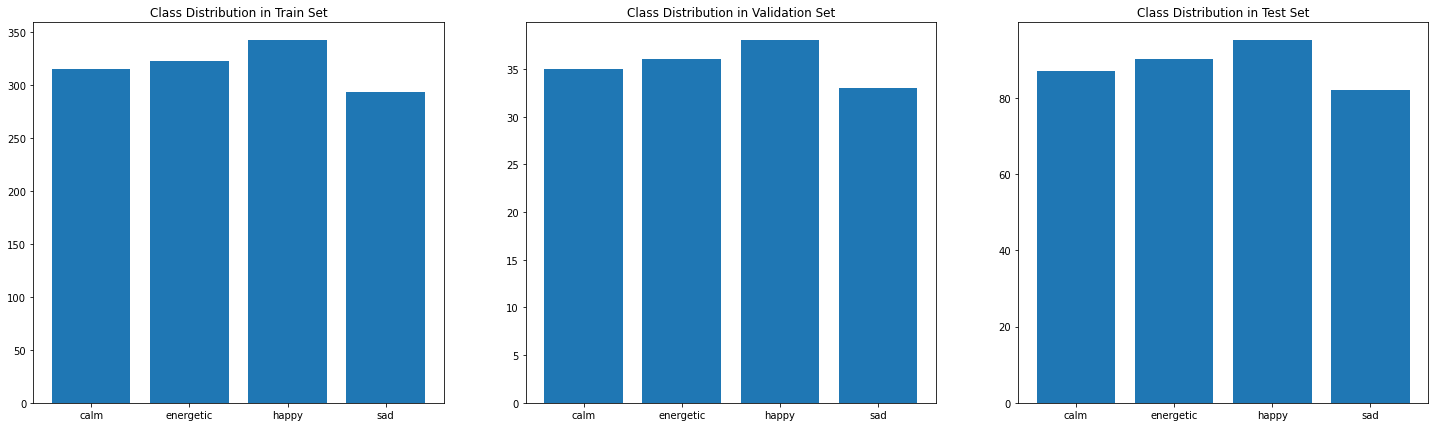

In [20]:
train_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt()
validation_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt()
test_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
axes[0].bar(train_count_df["variable"], train_count_df["value"])
axes[0].set_title('Class Distribution in Train Set')

# Validation
axes[1].bar(validation_count_df["variable"], validation_count_df["value"])
axes[1].set_title('Class Distribution in Validation Set')

# Test
axes[2].bar(test_count_df["variable"], test_count_df["value"])
axes[2].set_title('Class Distribution in Test Set')


In [21]:
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [22]:
train_dataset

# for imbalanced data

In [23]:
# Weighted Sampling
# First, we obtain a list called target_list which contains all our outputs. 
# This list is then converted to a tensor and shuffled.
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [24]:
# Then, we obtain the count of all classes in our training set. 
# We use the reciprocal of each count to obtain it’s weight.
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([0.0032, 0.0031, 0.0029, 0.0034])


In [25]:
# WeightedRandomSampler expects a weight for each sample. 
class_weights_all = class_weights[target_list]

In [26]:
# initialize our WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

# Model Parameters

In [27]:
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.1
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 4

# Dataloader

In [28]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# Define Neural Net Architecture


In [29]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [31]:
# Initialize the model, optimizer, and loss function. 
# Transfer the model to GPU. 
# We’re using the nn.CrossEntropyLoss because this is a multiclass classification problem. 
# We don’t have to manually apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. 
# However, we need to apply log_softmax for our validation and testing.
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [32]:
# function to calculate accuracy per epoch
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [33]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [34]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.72938 | Val Loss: 3.37975 | Train Acc: 67.900| Val Acc: 52.113
Epoch 002: | Train Loss: 0.53290 | Val Loss: 1.83400 | Train Acc: 76.500| Val Acc: 59.155
Epoch 003: | Train Loss: 0.52869 | Val Loss: 0.39640 | Train Acc: 77.700| Val Acc: 85.211
Epoch 004: | Train Loss: 0.50375 | Val Loss: 0.48868 | Train Acc: 76.900| Val Acc: 80.986
Epoch 005: | Train Loss: 0.50681 | Val Loss: 0.42357 | Train Acc: 77.900| Val Acc: 85.915
Epoch 006: | Train Loss: 0.46192 | Val Loss: 0.34556 | Train Acc: 80.300| Val Acc: 84.507
Epoch 007: | Train Loss: 0.45345 | Val Loss: 0.38133 | Train Acc: 78.500| Val Acc: 86.620
Epoch 008: | Train Loss: 0.46689 | Val Loss: 0.56235 | Train Acc: 80.200| Val Acc: 71.127
Epoch 009: | Train Loss: 0.49081 | Val Loss: 0.63887 | Train Acc: 76.700| Val Acc: 77.465
Epoch 010: | Train Loss: 0.50891 | Val Loss: 0.58427 | Train Acc: 77.100| Val Acc: 73.239


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

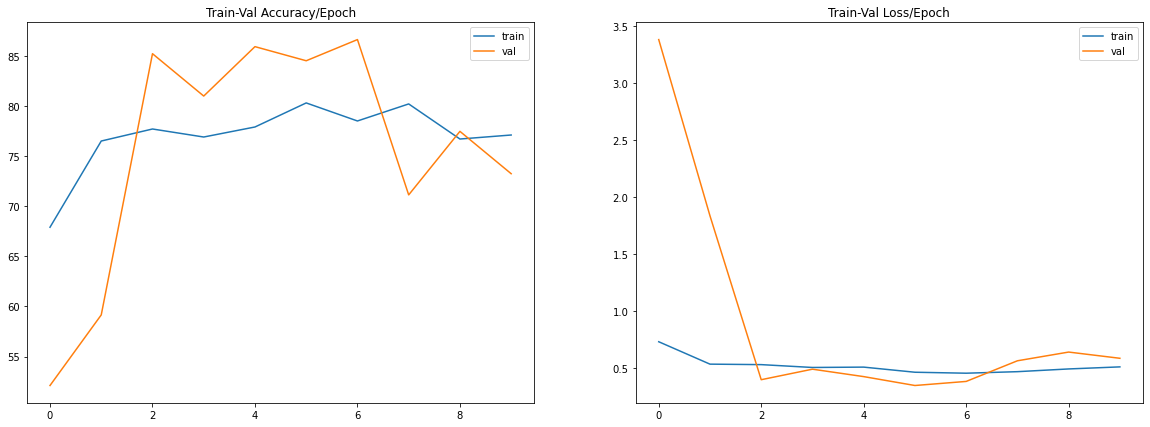

In [54]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
axes[0].plot(train_val_acc_df[train_val_acc_df["variable"]=='train']["epochs"], train_val_acc_df[train_val_acc_df["variable"]=='train']["value"],label = "train")
axes[0].plot(train_val_acc_df[train_val_acc_df["variable"]=='val']["epochs"], train_val_acc_df[train_val_acc_df["variable"]=='val']["value"],label = "val")
axes[0].set_title('Train-Val Accuracy/Epoch')
axes[0].legend()

axes[1].plot(train_val_loss_df[train_val_loss_df["variable"]=='train']["epochs"], train_val_loss_df[train_val_loss_df["variable"]=='train']["value"],label = "train")
axes[1].plot(train_val_loss_df[train_val_loss_df["variable"]=='val']["epochs"], train_val_loss_df[train_val_loss_df["variable"]=='val']["value"],label = "val")
axes[1].legend()
axes[1].set_title('Train-Val Loss/Epoch')

# Test the model

In [68]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

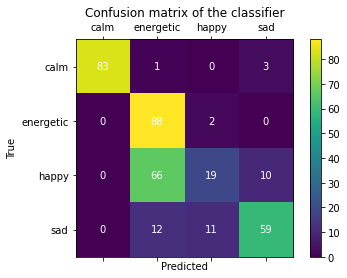

In [78]:
cm = confusion_matrix(y_test, y_pred_list)
confusion_matrix_df = pd.DataFrame(cm).rename(columns=idx2class, index=idx2class)
labels = confusion_matrix_df.columns.tolist()
# plt.imshow(confusion_matrix_df)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()

In [70]:
confusion_matrix_df

,calm,energetic,happy,sad
calm,83,1,0,3
energetic,0,88,2,0
happy,0,66,19,10
sad,0,12,11,59


In [79]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       1.00      0.95      0.98        87
           1       0.53      0.98      0.68        90
           2       0.59      0.20      0.30        95
           3       0.82      0.72      0.77        82

    accuracy                           0.70       354
   macro avg       0.74      0.71      0.68       354
weighted avg       0.73      0.70      0.67       354

